## Inhaltliche Analyse

Wir kennen nun die Statistik der Metadaten und einige Korrelationen, die uns zuversichtlich stimmen, dass der Transport-Flair des Technology-Subreddit gut geeignet für unsere Analyse ist.

Allerdings müssen wir noch die inhaltliche Seite überprüfen. So wäre es z.B. möglich, dass das Reddit voller Spam-Nachrichten ist oder die Diskussion trotz des Namens in eine völlig andere Richtung gehen. Dazu müssen wir die Texte analysieren.

Wir laden zunächst die Title und Texte aus der Datenbank ein: 

In [1]:
import pandas as pd

In [2]:
posts = pd.read_csv("transport-all-comments.csv.xz", parse_dates=["created_utc"])

Um die einzelnen Wörter zu zählen, ist der `Counter` aus dem `collections`-Paket von Python optimal:

In [3]:
from collections import Counter

Wir betrachten zunächst die Titel und müssen diese nun in Wörter zerlegen. [Tokenisierung](https://de.wikipedia.org/wiki/Tokenisierung) ist ein nicht-triviales Problem, das man normalerweise mit spezieller Software wie etwas [spaCy](https://spacy.io) lösen sollte. Das sparen wir uns allerdings hier und nutzen einen einfache `regex`-Tokenizer, weil wir sonst sehr lange auf die Ergebnisse waren müssten.

In [4]:
import regex as re
from tqdm.auto import tqdm
title_counter = Counter([w.lower() for t in tqdm(posts["text"]) for w in re.findall(r'[\w-]*\p{L}[\w-]*', t)])

  0%|          | 0/978104 [00:00<?, ?it/s]

Der `title_counter` verfügt über eine `most_common`-Funktion, mit der wir uns die häufigsten Wörter ausgeben lassen könnten. Stattdessen nutzen wir Wordclouds, die uns eine intuitive Visualisierung bieten:

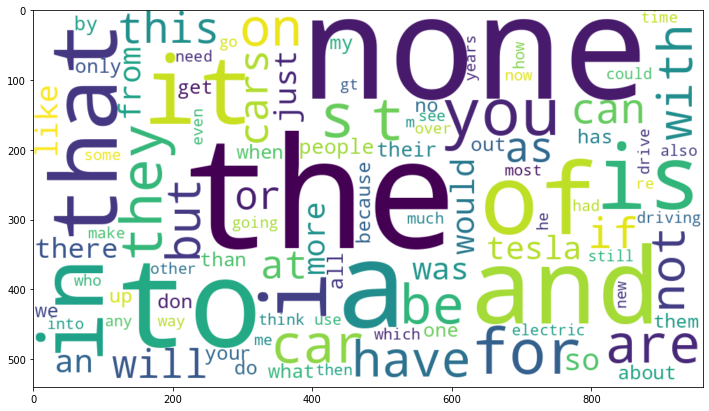

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
wc.generate_from_frequencies(title_counter)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')

Leider kann man außer sehr allgemeinen Wörtern nicht viel erkennen. Wir müssen die Ergebnisse filtern und die sog. *Stoppworte* eliminieren. Zum Glück gibt es dazu fertige Listen, die wir hier noch etwas ergänzen: 

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
for w in "removed deleted post message account moderators http https www youtube com \
          watch gt look looks feel test know think go going submission link apologize \
          inconvenience don want automatically based buy compose good image karma like \
          lot need people self shit sound sounds spam submitting subreddit things \
          video way years time days doesn en fuck money org read reddit review \
          right said says subreddit subreddits sure thank try use videos wiki \
          wikipedia work ll thing point ve actually wait hello new amp better \
          isn yeah probably pretty yes didn pay long posts commenting portion \
          contribute questions unfortunately allowed submissions gifs pics sidebar".split(" "):
    stopwords.add(w)

Wir nutzen diese Liste und lassen einbuchstabige Wörter auch gleich weg:

In [8]:
title_counter = Counter([w for t in tqdm(posts["text"].str.lower())
                            for w in re.findall(r'[\w-]*\p{L}[\w-]*', t)
                               if (w not in stopwords) and (len(w) > 1)
                        ])

  0%|          | 0/978104 [00:00<?, ?it/s]

Die Wordcloud kann wieder genauso erzeugt werden:

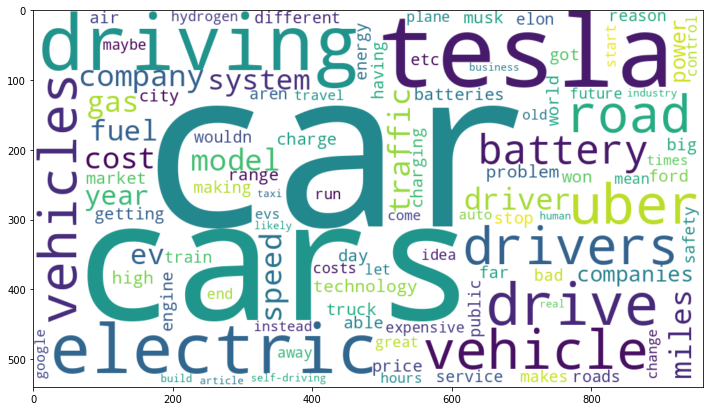

In [9]:
wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
wc.generate_from_frequencies(title_counter)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')

Das sieht schon sehr gut aus und passt genau zu unserem Thema. Wunderbar, das bedeutet, dass wir die richtige Datenmenge ausgewählt haben und auch unsere Klassifikation gut funktioniert hat.

Analysieren wir zum Vergleich noch den Text der Toplevel-Posts:

In [16]:
text_counter = Counter([w for t in tqdm(posts[posts["parent_id"].isna()]["text"].str.lower()) 
                            for w in re.findall(r'[\w-]*\p{L}[\w-]*', t)
                               if (w not in stopwords) and (len(w) > 1)
                        ])

  0%|          | 0/99626 [00:00<?, ?it/s]

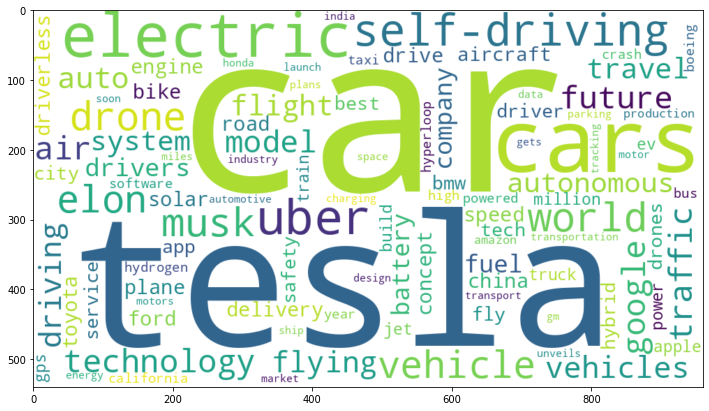

In [17]:
wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
wc.generate_from_frequencies(text_counter)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')

Auch das passt prima und sieht sehr ähnlich aus wie die Ergebnisse inkl. der Kommentare. In anderen Worten bedeutet das, dass die Kommentare gut zu den Posts passen - wunderbar!

## Topic Modelle

Bisher haben wir die inhaltlichen Aspekte der Posts nur durch Zählen der Wörter berücksichtigt. Allerdings interessieren uns auch Nischen-Themen, die mir mithilfe sog. [Topic Modelle](https://en.wikipedia.org/wiki/Topic_model) aufdecken können.

Hierbei handelt es sich um ein unüberwachtes Machine Learning-Verfahren zur Aufdeckung der latenten Struktur großer Datenmengen.

Am häufigsten wird für Topic Models die sog. [LDA-Methode](https://de.wikipedia.org/wiki/Latent_Dirichlet_Allocation) eingesetzt, die mit stochastischem Sampling funktioniert. Da die Berechnung sehr lange benötigt und es sich in vielen Projekten gezeigt hat, dass die Ergebnisse des NMF-Algorithmus oft (mindestens) genauso gut sind, nutzen wir diesen.

Dafür werden die Texte im ersten Schritt mit TD/IDF vektorisiert:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(posts['text'])

Nun können wir das Topic Model instanziieren und berechnen lassen. Bei (fast) allen Topic Models müssen wir die Anzahl der Topics vorgeben. Es gibt bestimmte Metriken wie Perplexität oder Kohärenz, mit denen sich die Güte des Modells bestimmen lässt. In unserem Fall arbeiten wir einfach mit 10 Topics:

In [19]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

Die Berechnung dauert normalerweise keine Minute, jetzt können wir die Daten visualisieren. Dafür nutzen wir eine kleine Hilfsfunktion, die über die Topics iteriert und Wordclouds als Ergebnisse darstellt:

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topic_model_summary(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        freq = {}
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            freq[feature_names[i].replace(" ", "_")] = topic[i]
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(freq)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')

Wir können uns nun die Wordclouds für die 10 Topics aus dem Topic Model ausgeben lassen:

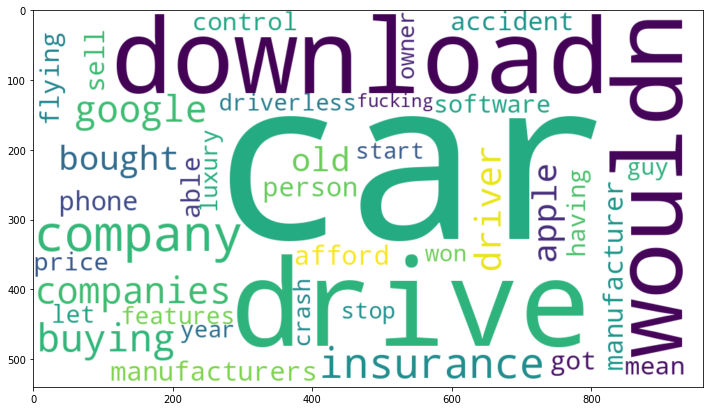

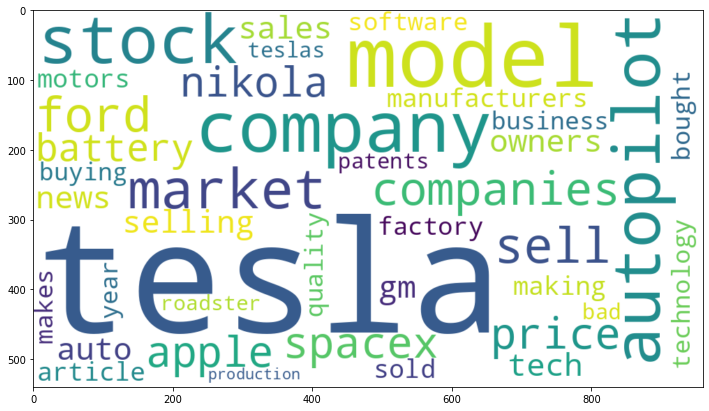

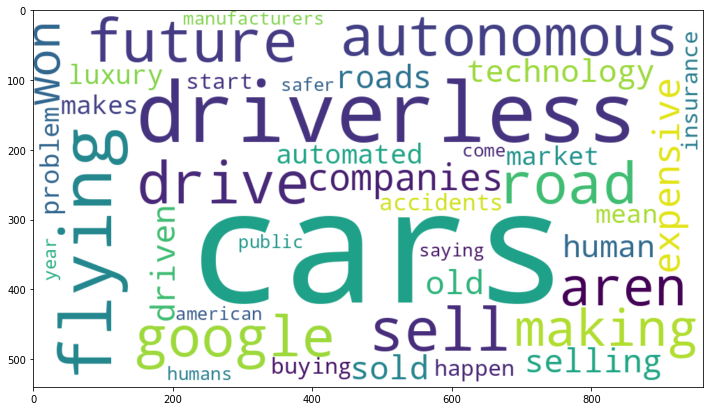

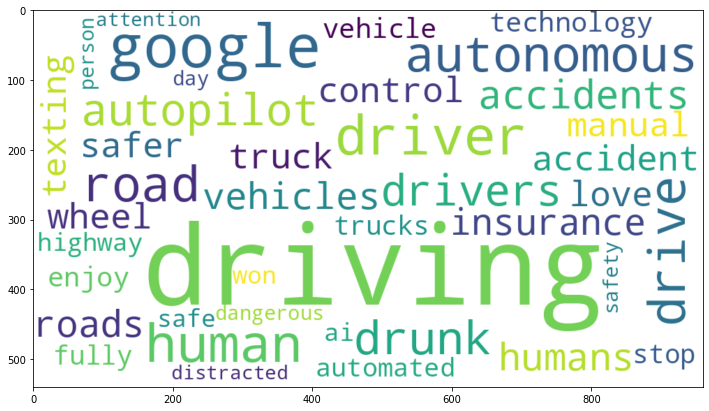

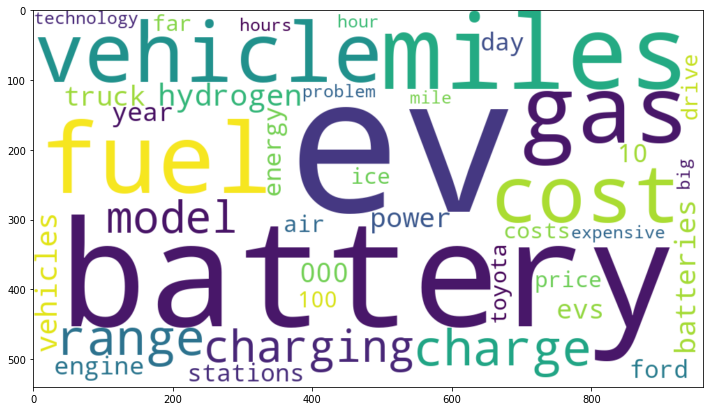

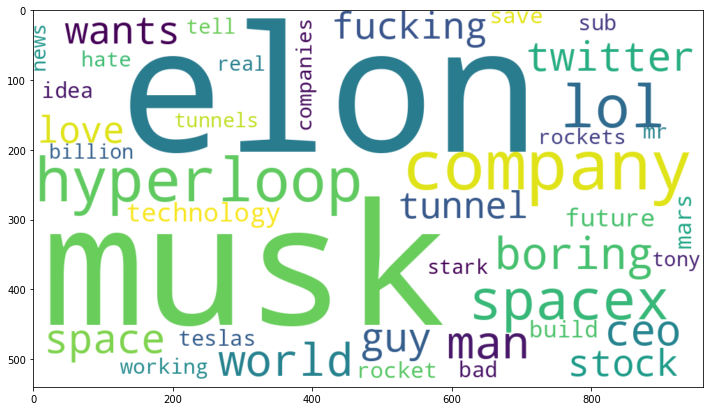

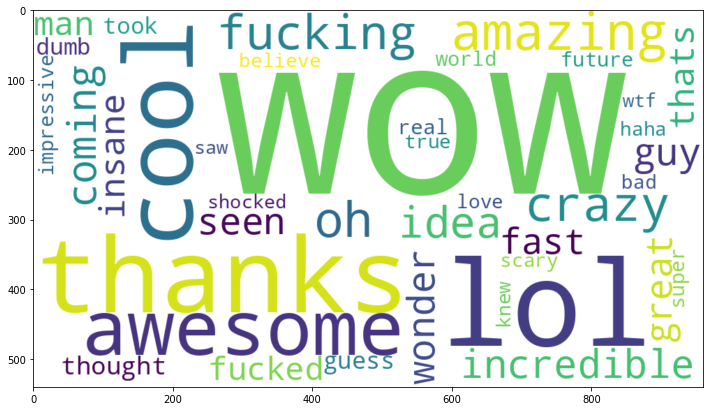

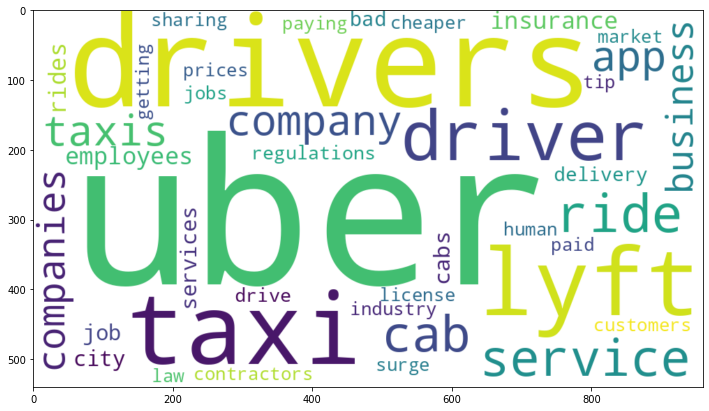

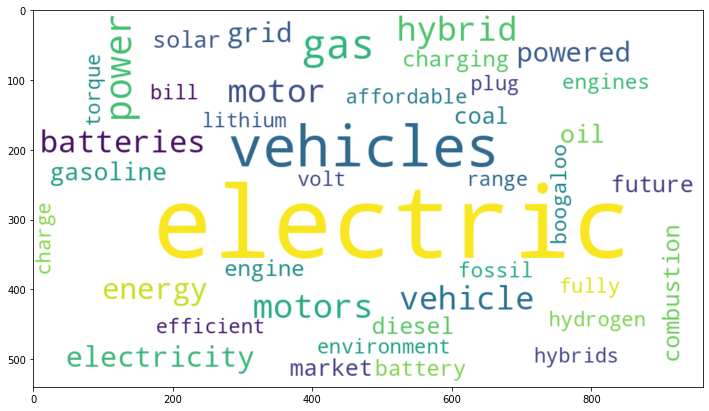

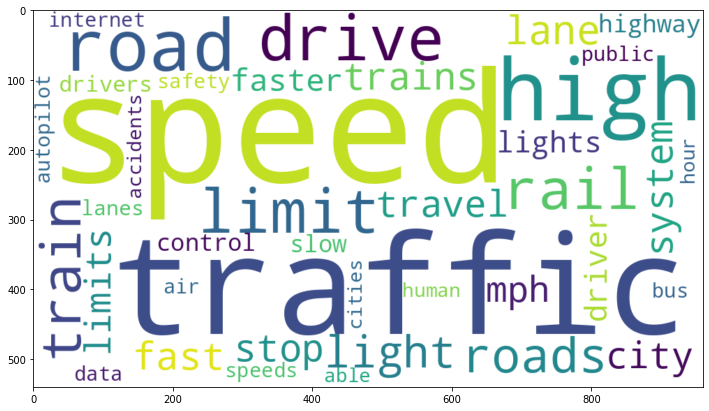

In [21]:
wordcloud_topic_model_summary(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), 40)

Plötzlich können wir auch Nischenthemen erkennen, die uns vorher verborgen waren. Das ist sehr praktisch, um Ideen für Trends zu identifizieren. Hiermit können wir außerdem erkennen, ob bestimmte Wörter möglicherweise noch eliminiert werden müssen (wie z.B. `deleted post`, das sich deswegen auch in den Stopwords findet).

Durch die Geschwindigkeit, mit der ein NMF-Topic Model berechnet werden kann, bietet sich diese Methode auch zur Qualitätssicherung an.